In [1]:
# Settings

# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as smf
import scipy.stats as si

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score

# define path
my_path = "/Users/meikeepauline/Desktop/IP/CaseStudy/"

# columns (not) to be analysed
except_column   = ["ID", "deflag"]
analysis_columns = ["var1_AQ","var2_AQ","var3_CL","var4_CL","var5_LF","var6_LF","var7_PE","var8_PE","var9_LF","var10_PE",
"var11_AQ","var12_PE","var13_PE","var14_LF","var15_PE","var16_AQ","var17_LF","var18_CL","var19_AQ","var20_AQ","var21_LF",
"var22_AQ","var23_PE","var24_LF","var25_LF","var26_LF"]

# parameters
test_sample_size = 0.3
seed = 31032023

# set pandas options to see all info of dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# remove specific  warnings
pd.options.mode.chained_assignment = None
plt.rcParams.update({'figure.max_open_warning': 0})

# Turn interactive plotting off
plt.ioff()

In [2]:
# import data
data = pd.read_excel(my_path + "DataPD.xlsx")

In [3]:
# create statistics for raw data set
print(data.head())          # print first 5 rows
print(data.info())          # print information of data (null, type)
print(data.describe())      # print statistics

# export result
data.describe().to_excel(my_path + "/Export/" + "Descriptive_statistics_before.xlsx")  

   ID  deflag   var1_AQ   var2_AQ    var3_CL   var4_CL   var5_LF   var6_LF  \
0   1       0  0.451877       NaN  22.369781  0.084089       NaN  0.398630   
1   2       0  5.516033 -0.110378  12.772155  0.139006  1.081491  0.023785   
2   3       0  0.781693 -0.023390        NaN  0.186470  0.543743  0.349677   
3   4       0  3.241453  0.372442        NaN  0.123212  0.781212  0.180893   
4   5       0  1.757127       NaN  14.341708  0.010445  0.703393  0.605375   

    var7_PE   var8_PE   var9_LF  var10_PE  var11_AQ  var12_PE  var13_PE  \
0  1.011158       NaN -0.013473 -0.000590  1.150207       NaN  0.050189   
1  1.041538  0.251213  0.030126  0.025606  1.099361       NaN  0.064654   
2  1.041045  0.000742  0.022277  0.006097  0.922969  0.546460       NaN   
3  1.001151  0.059936  0.056857  0.007628  1.080822  0.669822       NaN   
4  1.017952  0.137188  0.010855 -0.000510  1.082658  0.765356  0.042959   

   var14_LF  var15_PE   var16_AQ  var17_LF   var18_CL  var19_AQ  var20_AQ  \
0  

In [4]:
# create distribution plots and boxplots
for col in data.columns[2:]:
    fig1 = plt.figure()
    sns.displot(data[col])
    plt.savefig(my_path + "/Plot/" + col + '_Distr.png')
    plt.close(fig1)

    fig2 = plt.figure()
    plt.title(col)
    sns.boxplot(data=data[col])
    plt.savefig(my_path + "/Plot/" + col + '_Boxplot.png')
    plt.close(fig2)

plt.close('all')

In [5]:
# data preparation: Outliers -> Winsorization, Values = 99 -> NaN

# Calculate Quantiles, Interquantile, Lower and Upper Limit, save in Dataframe perc
def quantiles(var):

    IQ = np.subtract(*np.nanpercentile(var, [75, 25]))
    Q25 = np.nanpercentile(var, 25)
    Q75 = np.nanpercentile(var, 75)
    UL = Q75+1.5*IQ
    LL = Q25-1.5*IQ

    return IQ, Q25, Q75, UL, LL

perc = data[analysis_columns].apply(quantiles)
Description = ['Interquantile', '25thQuantile', '75thQuantile', 'Upper Limit', 'Lower Limit']
perc.insert(0, 'Description', Description)

# export result
perc.to_excel(my_path + "/Export/" + "IQR.xlsx")  

# Set values = 99 as NaN, Winsorize values above UL and below LL to UL/LL, save in Dataframe data_nO
data_nO = data[except_column]

for col in data.columns[2:]:
    data_nO[col] = np.where(data[col] == 99, np.NaN, np.where(data[col] > perc.iloc[3][col], perc.iloc[3][col], np.where(data[col] < perc.iloc[4][col], perc.iloc[4][col], data[col])))
    #data_nO[col] = np.where(data[col] > perc.iloc[3][col], np.NaN, np.where(data[col] < perc.iloc[4][col], np.NaN, data[col]))
    #data_nO[col] = np.where(data[col] > perc.iloc[3][col], perc.iloc[3][col], np.where(data[col] < perc.iloc[4][col], perc.iloc[4][col], data[col]))

# Create new variable "Number of missing variables"
data_nO["Num_of_Miss"] = data_nO.isnull().sum(axis=1)

In [6]:
# data preparation: Missing value treatment and standardization

# Number of missing values to be replaced
print("Missing values: \n", data_nO.isna().sum())

# Caclulate Average, Median, etc. and save in Dataframe stats
stats = data_nO[analysis_columns].describe().reset_index()

data_fin = data[except_column]
data_fin['Num_of_Miss'] = data_nO['Num_of_Miss']

for col in data_nO.columns[2:-1]:
    data_fin[col] = data_nO[col].fillna(stats.iloc[5][col])

# Re-Caclulate Average, Median, etc. and save in Dataframe stats
stats = data_fin[analysis_columns].describe().reset_index()

# export result
stats.to_excel(my_path + "/Export/" + "Descriptive_statistics_after.xlsx")  

# Standardization of variables, save in Dataframe data_fin
#for col in data_fin.columns[2:-1]:
#    data_fin[col] = (data_fin[col] - stats.iloc[1][col])/stats.iloc[2][col]

Missing values: 
 ID                0
deflag            0
var1_AQ         390
var2_AQ        2373
var3_CL        3645
var4_CL         807
var5_LF        3882
var6_LF        2977
var7_PE        2215
var8_PE        3175
var9_LF        1407
var10_PE       4213
var11_AQ       5067
var12_PE       2011
var13_PE       4392
var14_LF        581
var15_PE       5583
var16_AQ       1464
var17_LF       2179
var18_CL       3060
var19_AQ       5113
var20_AQ        712
var21_LF       1394
var22_AQ       5428
var23_PE       4042
var24_LF       3377
var25_LF       4389
var26_LF       4901
Num_of_Miss       0
dtype: int64


In [7]:
# create distribution plots after outlier and missing data treatment
for col in data_fin.columns[2:]:
    fig = plt.figure()
    sns.displot(data_fin[col])
    plt.savefig(my_path + "/Plot/" + col + '_Distr_after.png')
    plt.close(fig)

plt.close('all')

In [8]:
# create correlation matrix
correlation = data_fin.corr()

# export result
correlation.to_excel(my_path + "/Export/" + "Correlation.xlsx")  

In [9]:
# splitting data into test and train
train, test = train_test_split(data_fin, test_size=test_sample_size, random_state=seed, stratify=data_fin['deflag'])

print(train['deflag'].value_counts())
print(test['deflag'].value_counts())

0    20633
1      367
Name: deflag, dtype: int64
0    8843
1     157
Name: deflag, dtype: int64


In [10]:
from scipy import stats

# Calculate AUC, GINI and plot ROC-curve

def plot_roc_curve(y, y_pred, gini, ks):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure()
    plt.plot(fpr, tpr, 'b--', label='%s AUC = %0.4f, GINI = %0.2f, KS = %s' % ('Model: ', roc_auc, gini, ks))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0, fontsize='small')
    plt.savefig(my_path + "/Plot/" + col + '_ROC.png')
    plt.close(fig)

gini_ks = pd.DataFrame(columns=['Variable', 'AUC', 'GINI', 'KS'])

for col in train.columns[2:]:
    AUC = roc_auc_score(train['deflag'], train[col])
    gini = 2 * AUC - 1
    ks = stats.ks_2samp(train[train['deflag'] == 0][col], train[train['deflag'] == 1][col]).statistic

    temp = pd.DataFrame([[col, AUC, gini, ks]],columns=['Variable','AUC', 'GINI', 'KS'])
    gini_ks = pd.concat([gini_ks, temp])

    plot_roc_curve(train['deflag'], train[col], gini, ks)

plt.close('all')

# export result
gini_ks.to_excel(my_path+ "/Export/" + "Gini.xlsx")  

In [11]:
# Correlation of variables with GINI values above selected threshold

# model1: GINI > 0.2
corr_var1 = train[["var2_AQ","var3_CL","var5_LF","var6_LF","var7_PE","var9_LF","var14_LF","var16_AQ","var18_CL","var24_LF","var26_LF"]].corr()
corr_var1.to_excel(my_path + "/Export/" + "Correlation_selectVAR_model1.xlsx")

# model2: GINI > 0.05
corr_var2 = train[["var1_AQ","var2_AQ","var3_CL","var4_CL","var5_LF","var6_LF","var7_PE","var8_PE","var9_LF","var10_PE","var11_AQ","var13_PE","var14_LF","var15_PE","var16_AQ","var18_CL","var19_AQ","var20_AQ","var21_LF","var22_AQ","var24_LF","var25_LF","var26_LF"]].corr()
corr_var2.to_excel(my_path + "/Export/" + "Correlation_selectVAR_model2.xlsx")  

In [12]:
# creation of probit-model

# selected variables for final model
# model 1: abs(GINI) > 0.2, corr. variables and variables with p-value > 0.05 removed
""" selected_variables = ["var2_AQ"
                     ,"var5_LF"
                     #,"var6_LF"
                     #,"var7_PE"
                     ,"var9_LF"
                     ,"var14_LF"
                     #,"var16_AQ"
                     #,"var18_CL"
                      ]  """

# model 2: abs(GINI) > 0.05, corr. variables and variables with p-value > 0.05 removed
selected_variables = ["var2_AQ"
                      ,"var5_LF"
                      ,"var6_LF"
                      ,"var7_PE"
                      ,"var9_LF"
                      ,"var14_LF"
                      ,"var16_AQ"
                      #,"var18_CL"
                      ,"var19_AQ"
                      ,"var21_LF"
                      #,"var22_AQ"
                      ,"var25_LF"
                      ]

# split data set into dependent and independent variables
X_train = smf.add_constant(train[selected_variables])
y_train = train["deflag"]
X_test = smf.add_constant(test[selected_variables])
y_test = test["deflag"]

# estimate model using training dataset
model=smf.Probit(y_train,X_train)
model.fit()
print(model.fit().summary())

# output coefficient
params = pd.DataFrame(model.fit().params,columns={'coef'},)
print(params)

Optimization terminated successfully.
         Current function value: 0.069714
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.069714
         Iterations 9
                          Probit Regression Results                           
Dep. Variable:                 deflag   No. Observations:                21000
Model:                         Probit   Df Residuals:                    20989
Method:                           MLE   Df Model:                           10
Date:                Tue, 28 Mar 2023   Pseudo R-squ.:                  0.2082
Time:                        10:07:04   Log-Likelihood:                -1464.0
converged:                       True   LL-Null:                       -1849.0
Covariance Type:            nonrobust   LLR p-value:                5.761e-159
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const 

In [13]:
# Apply model on test and training sample, calculate PD and assign to non-default (0) or default (1) class
PD_threshold = 0.025

def normsdist(z):
    z = si.norm.cdf(z,0.0,1.0)
    return (z)

def rating(var):
    if var*100 < 0.05:
        rating = 'AAA'
    elif var*100 >= 0.05 and var*100 < 0.09:
        rating = 'AA'
    elif var*100 >= 0.09 and var*100 < 0.23:
        rating = 'A'
    elif var*100 >= 0.23 and var*100 < 1.16:
        rating = 'BBB'
    elif var*100 >= 1.16 and var*100 < 5.44:
        rating = 'BB'
    elif var*100 >= 5.44 and var*100 < 14.21:
        rating = 'B'
    else:
        rating = 'CCC'

    return rating
        
def model_score(df):
    df['deflag_score'] = params['coef'][0] \
                        + df['var2_AQ'] * params['coef'][1] \
                        + df['var5_LF'] * params['coef'][2] \
                        + df['var6_LF'] * params['coef'][3] \
                        + df['var7_PE'] * params['coef'][4] \
                        + df['var9_LF'] * params['coef'][5] \
                        + df['var14_LF'] * params['coef'][6] \
                        + df['var16_AQ'] * params['coef'][7] \
                        + df['var19_AQ'] * params['coef'][8] \
                        + df['var21_LF'] * params['coef'][9] \
                        + df['var25_LF'] * params['coef'][10] 
    df['deflag_pred_Probit'] = normsdist(df['deflag_score'])
    df['deflag_pred'] = np.where(df['deflag_pred_Probit'] > PD_threshold, 1, 0)
    df['RatingClass'] = df['deflag_pred_Probit'].apply(rating)

    df['RatingClass'] = pd.Categorical(df['RatingClass'], ['AAA','AA','A','BBB','BB','C'])

model_score(X_test)
y_pred = X_test['deflag_pred']

model_score(X_train)

[[7312 1531]
 [  53  104]]
GINI: 
 train:  0.7152443950070195 
 test:  0.6779647221776053


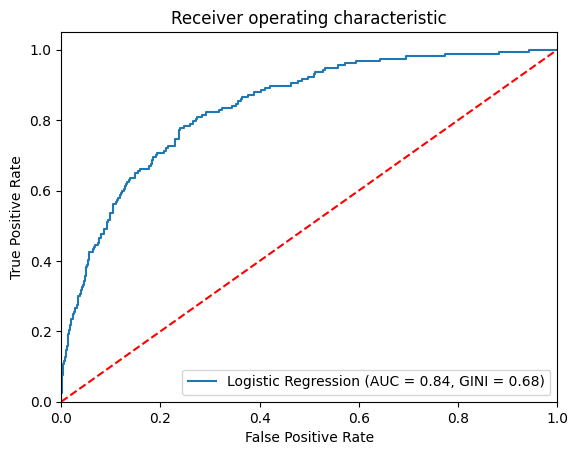

In [14]:
# validation of model

# confusion matrix based on test dataset between predicted and actual deflag
print(confusion_matrix(y_test, y_pred))

# ROC curve and GINI of final model
fpr, tpr, thresholds = roc_curve(y_test, X_test['deflag_pred_Probit'])
logit_roc_auc = roc_auc_score(y_test, X_test['deflag_pred_Probit'])

logit_gini_train = 2 * roc_auc_score(y_train, X_train['deflag_pred_Probit']) - 1
logit_gini_test = 2 * roc_auc_score(y_test, X_test['deflag_pred_Probit']) - 1
print('GINI: \n', 'train: ', logit_gini_train, '\n test: ', logit_gini_test)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f, GINI = %0.2f)' % (logit_roc_auc, logit_gini_test))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig(my_path + "/Plot/" + 'FinalModel' + '_ROC.png')
plt.show()
plt.close('all')

In [15]:
# plot distribution of score and PD

def plot_score(df,name):
    fig1 = plt.figure()
    sns.displot(df['deflag_score'])
    plt.xlabel("Modelscore")
    plt.savefig(my_path + "/Plot/" + str(name) + '_Modelscore.png')
    plt.close(fig1)

    fig2 = plt.figure()
    sns.displot(df['deflag_pred_Probit'])
    plt.xlabel("PD")
    plt.savefig(my_path + "/Plot/" + str(name) + '_PD.png')
    plt.close(fig2)

    fig3 = plt.figure()
    sns.displot(df['RatingClass'])
    plt.xlabel("RatingClass")
    plt.savefig(my_path + "/Plot/" + str(name) + '_RatingClass.png')
    plt.close(fig3)

    plt.close('all')

plot_score(X_test,'testsample')
plot_score(X_train,'trainsample')

In [16]:
# PD of selected three banks 

model_score(data_fin)
plot_score(data_fin,'Whole_dataset')
print(data_fin[data_fin['ID'].isin([47, 484, 2741])])

        ID  deflag  Num_of_Miss   var1_AQ   var2_AQ    var3_CL   var4_CL  \
46      47       0            2  1.297843  0.752001  14.739945  0.049510   
483    484       0            1  0.007342  0.914403  10.024060  0.025081   
2740  2741       0            1 -1.477951  0.393809  31.434065  0.103426   

       var5_LF   var6_LF   var7_PE   var8_PE   var9_LF  var10_PE  var11_AQ  \
46    0.966505  0.079427  1.013782  0.133381  0.023360  0.005585  0.835465   
483   0.671865  0.447787  1.008155  0.246483 -0.012301 -0.005537  1.013033   
2740  0.459135  0.097244  1.017527  0.026099  0.043698 -0.000091  0.997024   

      var12_PE  var13_PE  var14_LF  var15_PE  var16_AQ  var17_LF   var18_CL  \
46    0.776917  0.033513  0.881394  3.329324  0.828554  0.875392   5.969945   
483   0.721655  0.022789  0.843211  7.338422  1.186191  0.683668  16.832164   
2740  0.723177  0.058149  1.042053  2.057101  0.163265  0.280532  16.832164   

      var19_AQ  var20_AQ   var21_LF  var22_AQ  var23_PE  var24_LF